# Calculate the steady state for the heat engine and the heat pump

Here we caculate the steady state for the system acting as a heat pump or a heat engine.

The heat engine is given by the potential
$$V(x,y)=-p_{1}x-p_{2}\exp(-0.5(-sin(2\pi x)-\sin(2\pi(0.5y+0.5))+2\cos(\pi(0.5y+0.5)))^2)+p_{3}(y)^4-p_{4}\cos(2\pi x)\cos(2\pi(0.5y+0.5))$$
For the heat engine and heat pump, you will find that you can change the following parameters:
* `Th` and `Tc`: The temperature of the hot and cold baths
* `coupling`: This is the parameter ${\mathcal R}\equiv \bar{\gamma} D\rho c_p V_{\Omega}/k^2_{B}T_{0}$
* `p`: an array with the paramters in the above potential

In [1]:
using Plots
using PGFPlotsX
using LaTeXStrings
using OffsetArrays
using LinearAlgebra
using Statistics
using Dates
using JLD2

# Choose mesh size

In [2]:
nx = 300
ny = 300

300

In [3]:
using BrownianDynamics

In [4]:
LinearAlgebra.BLAS.set_num_threads(8)

norm([du; sum(u[1:nn]) * dx * dy - 1]) / nn = 2.8607656917395632e-5
 50.398870 seconds (23.95 M allocations: 12.728 GiB, 6.36% gc time)
sum(Jx) * dx * dy = -0.006706387632956162
(norm(flux!(copy(u0), u_steady_heat_engine, params_heat_engine, 0)) / nx) / ny = 2.3210091478621536e-5


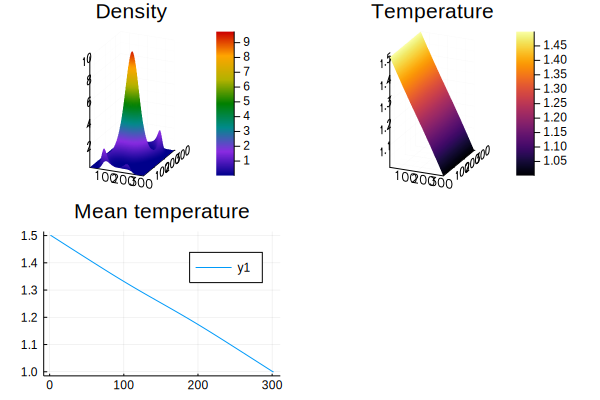

In [5]:
xx = range(0,stop=1,length=nx)
yy = range(-1,stop=1,length=ny)
## Choose parameters.
Tc = 1.0; Th = 1.5; coupling = 10.0; p = [0.2,15,5,2]
u0,params_heat_engine = create_system(xx,yy,Tc,Th,coupling,p;potential_type=:curved_channel)
## Solve for the steady state.
@time u_steady_heat_engine = solve_steady_state(u0,params_heat_engine;maxiters=15,steadytol=1e-10)
Jx,Jy = density_current((xx,yy),u_steady_heat_engine,params_heat_engine)
# Jx = params_heat_engine.Jx
# Jy = params_heat_engine.Jy
dx = params_heat_engine.dx
dy = params_heat_engine.dy
@show sum(Jx)*dx*dy
@show norm(flux!(copy(u0),u_steady_heat_engine,params_heat_engine,0))/nx/ny
## Visualize.
p1 = surface(reshape(u_steady_heat_engine[1:nx*ny],nx,ny),color=:darktest)
title!("Density")
p2 = surface(reshape(u_steady_heat_engine[nx*ny+1:end],nx,ny))
title!("Temperature")
Tsol_heat_engine = reshape(u_steady_heat_engine[(nx*ny+1):end],nx,ny)
Tsol_heat_engine = [ones(nx)*Th Tsol_heat_engine ones(nx)*Tc]
p3 = plot([mean(Tsol_heat_engine[:,i]) for i in 1:nx+2])
title!("Mean temperature")
plot(p1,p2,p3)

norm([du; sum(u[1:nn]) * dx * dy - 1]) / nn = 5.72773786596815e-8
 44.271628 seconds (24.73 k allocations: 11.654 GiB, 7.26% gc time)
(norm(flux!(copy(u0), u_steady_heat_pump, params_heat_pump, 0)) / nx) / ny = 4.701224480572756e-8


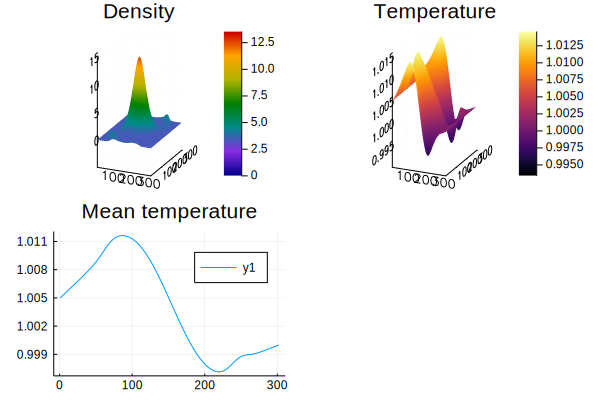

In [6]:
xx = range(0,stop=1,length=nx)
yy = range(-1.0,stop=1.0,length=ny)
## Choose parameters.
Tc = 1.0; Th = 1.005; coupling = 0.2; p = [0.2,15,5,2]
u0,params_heat_pump = create_system(xx,yy,Tc,Th,coupling,p;potential_type=:curved_channel)
## Solve for the steady state.
@time u_steady_heat_pump = solve_steady_state(u0,params_heat_pump;maxiters=15,steadytol=1e-14,autodiff=false)
@show norm(flux!(copy(u0),u_steady_heat_pump,params_heat_pump,0))/nx/ny
## Visualize.
p1 = surface(reshape(u_steady_heat_pump[1:nx*ny],nx,ny),color=:darktest)
title!("Density")
p2 = surface(reshape(u_steady_heat_pump[nx*ny+1:end],nx,ny))
title!("Temperature")
Tsol_heat_pump = reshape(u_steady_heat_pump[(nx*ny+1):end],nx,ny)
Tsol_heat_pump = [ones(nx)*Th Tsol_heat_pump ones(nx)*Tc]
p3 = plot([mean(Tsol_heat_pump[:,i]) for i in 1:nx+2])
title!("Mean temperature")
plot(p1,p2,p3)

# Save data

To make the plot in the paper, you will have to run the file `data/stream/plot_heat_engine.jl`.

In [7]:
date = Dates.today()

xx = range(0,stop=1,length=nx)
yy = range(-1,stop=1,length=ny)
fname = "data/steady_state_heat_engine"
p = [0,10,5,4]
potential = (x,y) -> (-p[1]*x-p[2]*exp(-0.5*(-sin(2π*x)-sin(2π*(0.5y+0.5))+2cos(π*(0.5y+0.5)))^2)
                      +p[3]*(y)^4-p[4]*cos(2π*x)*cos(2π*(0.5y+0.5)))
V_equilibrium = [potential(x,y) for x in xx, y in yy]
u_steady = collect(u_steady_heat_engine)
params = params_heat_engine
T0 = Tc
@save "$(fname).jld" u_steady params xx yy T0 V_equilibrium
@save "$(fname)$(date).jld" u_steady params xx yy T0 V_equilibrium
# contour([potential(x,y) for x in xx, y in yy])

In [8]:
@show fname = "data/steady_state_heat_pump"

u_steady = collect(u_steady_heat_pump)
params = params_heat_pump
@save "$(fname).jld" u_steady params xx yy T0 V_equilibrium
@save "$(fname)$(date).jld" u_steady params xx yy T0 V_equilibrium

fname = "data/steady_state_heat_pump" = "data/steady_state_heat_pump"


## Calculate the efficiency of the engine for multiple parameter values

In [9]:
function efficiency(work,Qh,Tc,Th)
    if (work < 0) && (Qh < 0)
        return work/(Qh*(1-Tc/Th))
    elseif (work > 0) && (Qh > 0)
        return (Qh*(1-Tc/Th))/work
    end
    zero(typeof(work))
end

efficiency (generic function with 1 method)

In [10]:
LinearAlgebra.BLAS.set_num_threads(1)

In [11]:
coupling_vec = [2.0 0.7 0.5]
Th_vec1 = range(1.0,stop=1.02,length=30)
Th_vec2 = range(Th_vec1[end]+step(Th_vec1),stop=2.0,length=30)
Th_vec = [Th_vec1 ; Th_vec2]
force = 0.2
Tc = 1.0; p = [force,15,5,2]
η = Array{Float64}(undef,length(Th_vec),length(coupling_vec))
drift = Array{Float64}(undef,length(Th_vec),length(coupling_vec))
@time Threads.@threads for i in 1:length(Th_vec)
    Th = Th_vec[i]
    for (j,coupling) in enumerate(coupling_vec)
        u0,params = create_system(xx,yy,Tc,Th,coupling,p;potential_type=:curved_channel)
        # Solve for the steady state.
        u_steady = solve_steady_state(u0,params;maxiters=15,steadytol=1e-10,autodiff=false,print_residual=false)
        dx = params.dx
        dy = params.dy
        Jx,Jy = density_current((xx,yy),u_steady,params)
        drift[i,j] = sum(Jx)*dx*dy
        work = force*sum(Jx)*dx*dy
        Tmat = params.Tmat
        heat_hot_bath = -sum((Tmat[:,0].-Tmat[:,1])/dy*coupling)*dx
        η[i,j] = efficiency(work,heat_hot_bath,Tc,Th)
    end
end

2569.401010 seconds (655.93 M allocations: 2.088 TiB, 2.58% gc time)


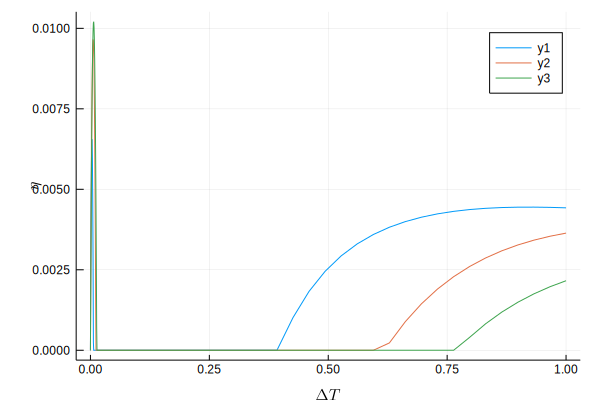

In [12]:
plot(Th_vec.-Tc,η)
xaxis!(L"\Delta T")
yaxis!(L"\eta")

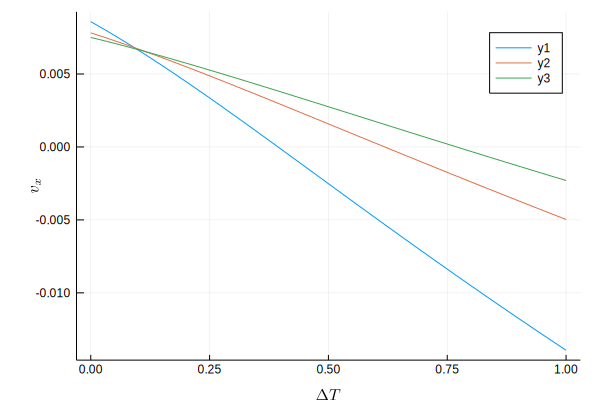

In [13]:
plot(Th_vec.-Tc,drift)
xaxis!(L"\Delta T")
yaxis!(L"v_x")

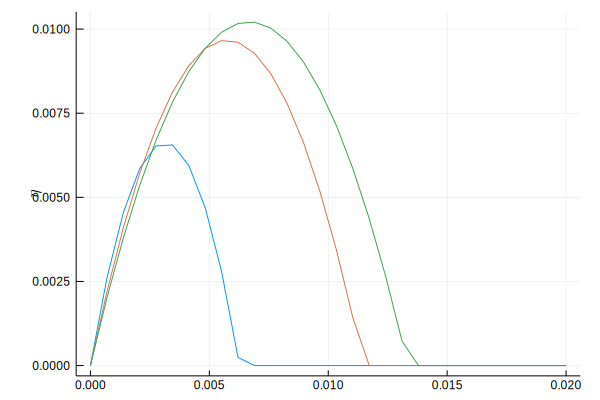

In [14]:
p1 = plot(Th_vec[1:length(Th_vec1)].-Tc,η[1:length(Th_vec1),:],leg=false)
yaxis!(L"\eta")

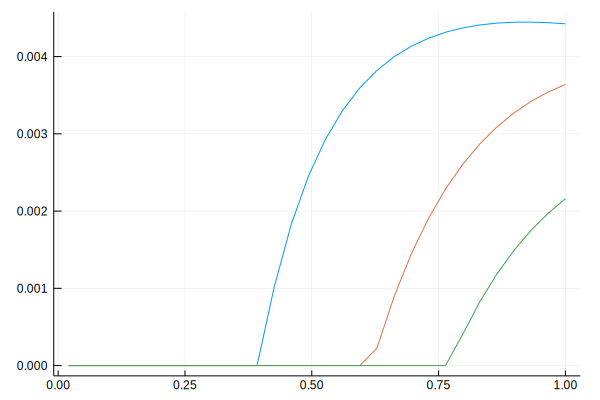

In [15]:
p2 = plot(Th_vec[length(Th_vec1)+1:end].-Tc,η[length(Th_vec1)+1:end,:],leg=false)

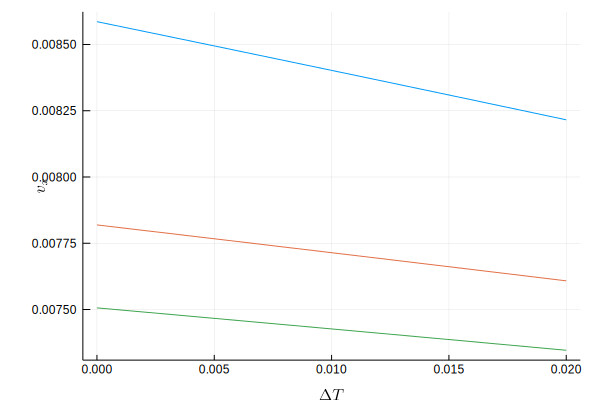

In [16]:
p3 = plot(Th_vec[1:length(Th_vec1)].-Tc,drift[1:length(Th_vec1),:],leg=false)
xaxis!(L"\Delta T")
yaxis!(L"v_x")

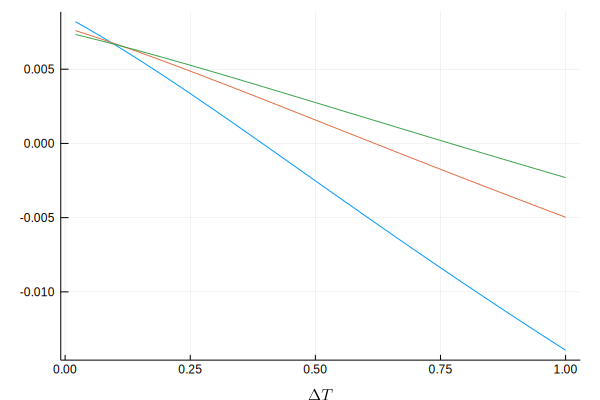

In [17]:
p4 = plot(Th_vec[length(Th_vec1)+1:end].-Tc,drift[length(Th_vec1)+1:end,:],leg=false)
xaxis!(L"\Delta T")

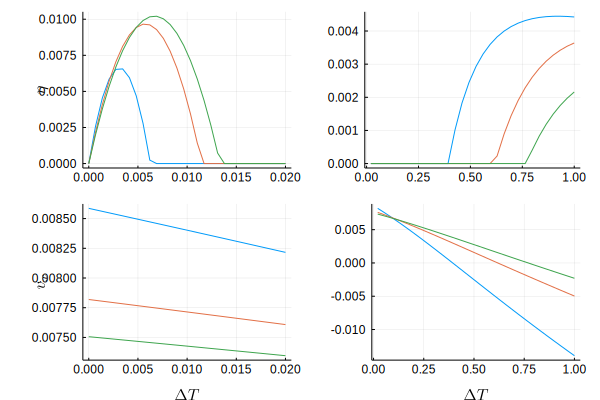

In [18]:
plot(p1,p2,p3,p4,layout=(2,2))

# Use the external plotting files to make a prettier figure of the steady state
The files include a lot more fomatting than is necessary for this notebook. The end result is saved into /data/figures.

In [19]:
run(`julia data/stream/plot_heat_engine.jl`)

/home/jackd/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)
/home/jackd/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'colorbar'
  s)


Process(`julia data/stream/plot_heat_engine.jl`, ProcessExited(0))